# MockSZ performance: internal performance and comparisons to SZpack

In this notebook, we investigate the internal performance and limits of `MockSZ`. We do this for the tSZ and kSZ signals. The goal is to see if the time performance of `MockSZ` is strongly affected by the choice of parameters. 

## Thermal SZ: effect of $T_e$ on calculation time

The first thing we investigate is the effect of $T_e$ on computation time. For this, we calculate the tSZ signal for a range of $T_e$, and record the time by passing the timer flag to the function call. Note that we do not pass a peculiar velocity to the `SinglePointing` object upon initialisation: this way we generate only the thermal effect, and we skip the kinematic effect.

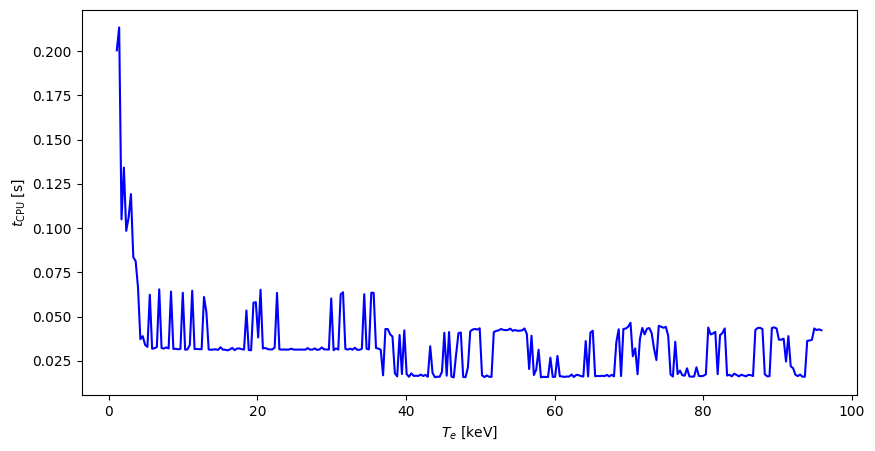

In [2]:
import matplotlib
import os

import numpy as np
import matplotlib.pyplot as pt

import MockSZ.Models as MModels

%matplotlib inline

num_Te = 300
Te = np.linspace(1.1, 95.9, num_Te)

numin = 100
numax = 1000

tau_e = 0.01
num_arr = 1000
nu = np.linspace(numin, numax, num=num_arr) * 1e9

fig, ax = pt.subplots(1,1, figsize=(10, 5))

times = []
for i in Te:
    simObj = MModels.SinglePointing(i, tau_e=tau_e, no_CMB=True)
    tSZ, time = simObj.getSingleSignal_tkSZ(nu, timer=True)
    times.append(time)
    label = r"$T_\mathrm{e}$" + f" = {i:.1f} KeV"
    
ax.plot(Te, times, c="blue")
ax.set_xlabel(r"$T_e$ [keV]")
ax.set_ylabel(r"$t_\mathrm{CPU}$ [s]")

pt.show()

It is clear that the low $T_e$ has the highest calculation time. However, on the whole, calculation time does not seem to be strongly correlated with $T_e$.

## Thermal and kinematic SZ: effect of $\nu$-array size, $n_\nu$, on calculation time

We will also check the correlation between $n_\nu$, the size of the frequency array $\nu$, and $t_\mathrm{CPU}$. For this experiment we fix $T_e=15.3$ keV. We can also compare this performance to the performance of `SZpack`. The fairest comparison would be to compare `MockSZ` to the 3D integral mode of `SZpack`, as this is also the integral that `MockSZ` solves.

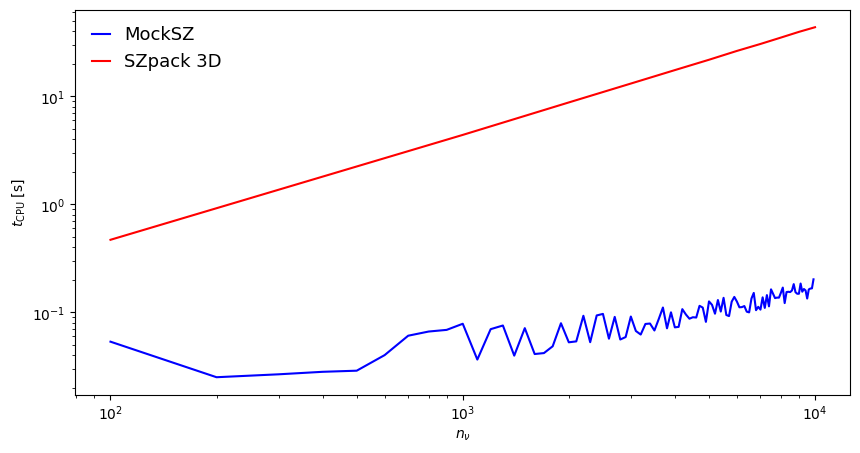

In [4]:
Te = 15.3

numin = 100
numax = 1000

tau_e = 0.01
v_pec = 1000
num_arr = np.arange(100, 10000, 100)

simObj = MModels.SinglePointing(Te, tau_e=tau_e, v_pec=v_pec, no_CMB=True)

fig, ax = pt.subplots(1,1, figsize=(10, 5))

times = []
for i in num_arr:
    nu = np.linspace(numin, numax, num=i) * 1e9
    
    tSZ, time = simObj.getSingleSignal_tkSZ(nu, timer=True)
    times.append(time)
    label = r"$T_\mathrm{e}$" + f" = {i:.1f} KeV"

name = os.path.join("resources", "SZpack_3D_times.txt")

nnu_pack = []                                                                                    
time_pack = []                                                                                   
with open(name, "r") as file:                                                             
    for line in file:                                                                     
        if line[0] == "#":                                                                
            continue                                                                      
        line = [float(x) for x in line.split(" ")]                                        
                                                                                          
        nnu_pack.append(line[0])                                                                 
        time_pack.append(line[-1])  

ax.loglog(num_arr, times, c="blue", label="MockSZ")
ax.set_xlabel(r"$n_\nu$")
ax.set_ylabel(r"$t_\mathrm{CPU}$ [s]")

ax.loglog(nnu_pack, time_pack, c="red", label="SZpack 3D")
ax.legend(frameon=False, prop={'size': 13},handlelength=1)

pt.show()

We can see that `MockSZ` significantly outperforms `SZpack` in the 3D integral mode when it comes to CPU time. Especially when evaluating many frequency points, `MockSZ` is faster by about two orders of magnitude. This is highly advantegous when using `MockSZ` to fit theoretical models to observed, noisy, signals. Also, because `MockSZ` solves the 3D collision integral instead of resorting to asymptotic evaluations or expansions, the signals are quite accurate. `SZpack` has a couple of fast modes as well, involving either asymptotic expansions or expanding in moments of $T_e$ and limiting the order, but these are less accurate than solving for the 3D integral numerically. But see the notebook on validation for a more thorough discussion of the accuracy of `MockSZ` and `SZpack`.